In [146]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

%matplotlib inline

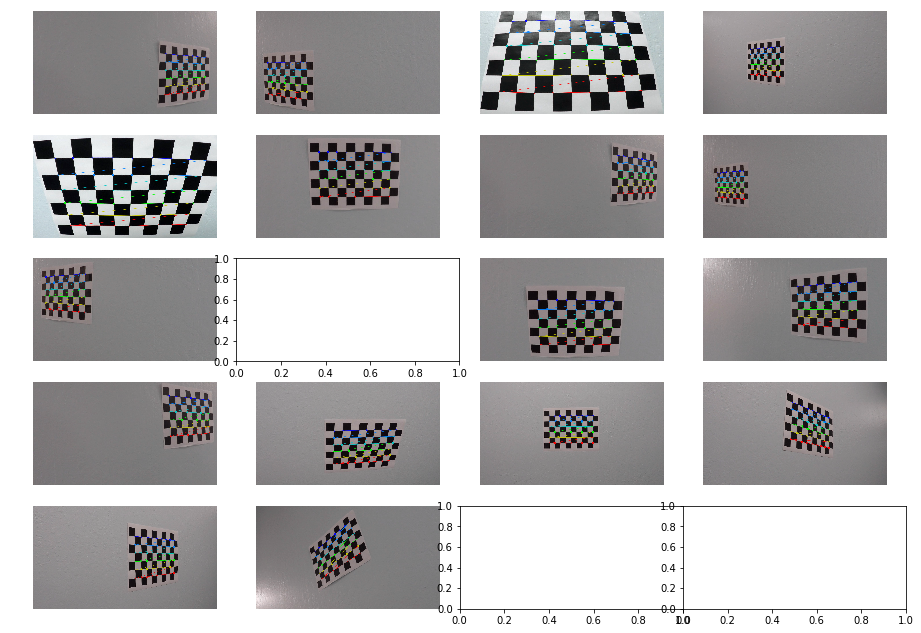

In [147]:
nx = 6
ny = 9
chesspoints = np.zeros((6*9,3), np.float32)
chesspoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = [] #3d
imgpoints = [] #2d

images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(chesspoints)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


True

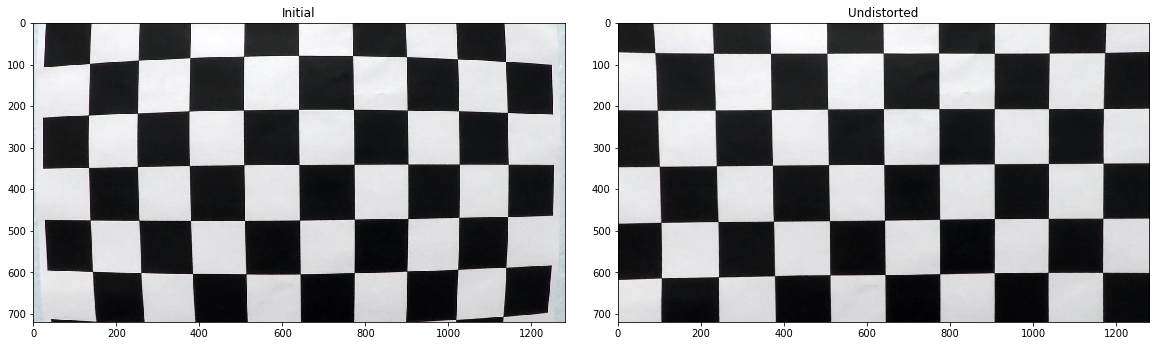

In [148]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2],None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .3, wspace=.1)
ax1.imshow(img)
ax1.set_title('Initial')
ax2.imshow(dst)
ax2.set_title('Undistorted')

cv2.imwrite('./output_images/Undistorted chessboard.jpg',dst)

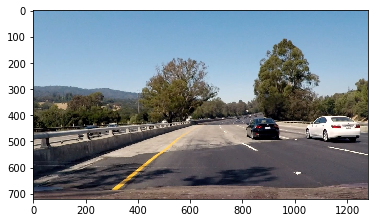

In [149]:
testImg = cv2.imread('./test_images/test4.jpg')
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
plt.imshow(testImg)

In [150]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [151]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [152]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        dev = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    if orient == 'y':
        dev = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abso = np.absolute(dev)
    scaled_sobel = np.uint8(255*abso/np.max(abso))
    sobinary_output = np.zeros_like(scaled_sobel)
    sobinary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sobinary_output

In [153]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.absolute(np.arctan2(np.absolute(sobel_y),np.absolute(sobel_x)))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [154]:
def thresholded_total(img):
    
    img_undistort = undistort(testImg)
    gray = cv2.cvtColor(img_undistort, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    outimg_sobel = abs_sobel_thresh(gray, 'x', 10, 200)
    outimg_dir = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined_condition = ((outimg_sobel == 1) & (outimg_dir == 1))

    color_threshold = 150
    outimg_color = (img[:,:,0] > color_threshold) & (img[:,:,1] > color_threshold)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    s_thresh = (100, 255)
    outimg_s = (S > s_thresh[0]) & (S <= s_thresh[1])
    l_thresh = (120, 255)
    outimg_l = (L > l_thresh[0]) & (L <= l_thresh[1])
    outimg = np.zeros_like(img[:,:,0])
    outimg[(outimg_color & outimg_l) & (outimg_s | combined_condition)] = 1

    mask = np.zeros_like(outimg)
    vertices = np.array([[0,h-1], [w/2, int(0.5*h)], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [vertices], 1)
    output = cv2.bitwise_and(outimg, mask)
    
    return output
    
    
    




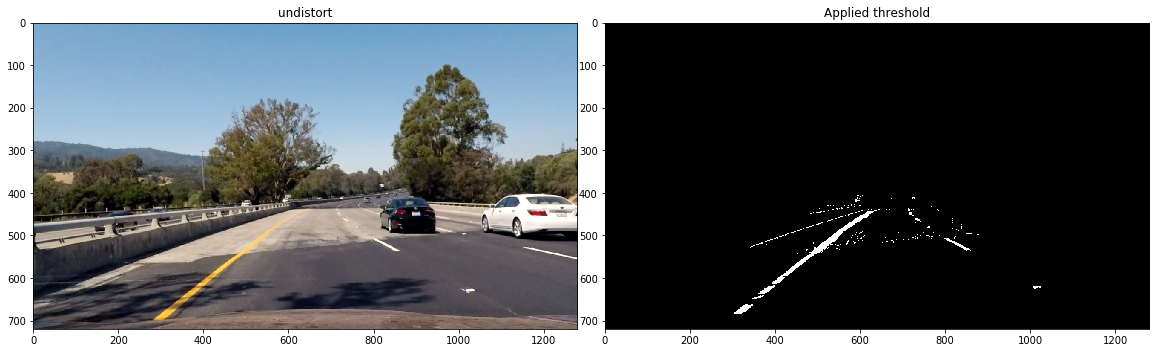

In [155]:
img = mpimg.imread('test_images/test4.jpg')
img_thre = thresholded_total(img)
img = undistort(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('undistort')
ax2.imshow(img_thre, cmap='gray')
ax2.set_title('Applied threshold')
#timg_thre = cv2.cvtColor(img_thre,cv2.COLOR_BGR2GRAY)
f.savefig('./output_images/Applied thre.jpg')
#cv2.imwrite('./output_images/Applied thre.jpg',img_thre)

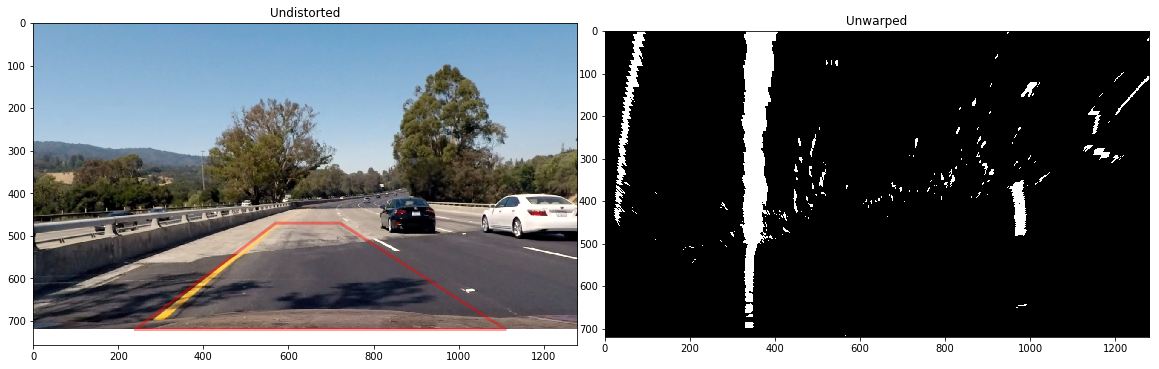

In [156]:
src = np.float32([(240,720),
                  (1110,720), 
                  (570,470), 
                  (722,470)])
dst = np.float32([(320,720),
                  (920,720),
                  (320,1),
                  (920,1)])

testImg_unwarp, M, Minv = unwarp(img_thre, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted')
ax2.imshow(testImg_unwarp, cmap='gray')
ax2.set_title('Unwarped')
#ttestImg_unwarp = 
f.savefig('./output_images/warped.jpg')
#cv2.imwrite('./output_images/warped.jpg',testImg_unwarp)

343 967


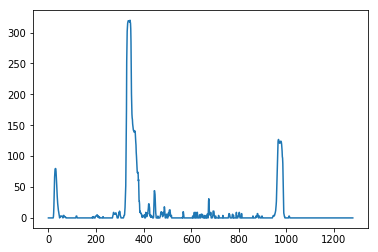

In [157]:
histogram = np.sum(testImg_unwarp[testImg_unwarp.shape[0]//2:,:], axis=0)

mid_point = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:mid_point])

rightx_base = np.argmax(histogram[mid_point:]) + mid_point

print(leftx_base, rightx_base)
plt.plot(histogram)

In [158]:
def find_lane_pixels(binary_warped):
    nwindows = 10
    margin = 80
    minpix = 40
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low =  leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]#None
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]#None

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    outimg = (rectangle_data, histogram)
  
    return left_fit, right_fit, left_lane_inds, right_lane_inds, outimg

In [159]:
def fit_polynomial(binary_warped):

    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = find_lane_pixels(binary_warped)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    rectangles = out_img[0]
    histogram = out_img[1]
        
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

    for rect in rectangles:

        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')


    return out_img,histogram, left_fit, right_fit, left_lane_inds, right_lane_inds

True

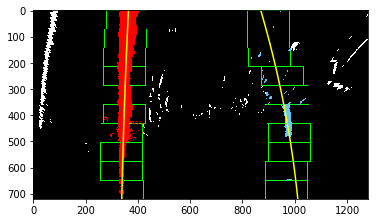

In [160]:
output,histogram,left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(testImg_unwarp)
plt.imshow(output)
cv2.imwrite('./output_images/fit line.jpg',output)

In [161]:
def find_lane(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):

    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]

    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]

    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    polyfit_right = np.polyfit(right_y, right_x, 2)

    ploty = np.linspace(0, num_rows-1, num_rows)
    left_x_predictions = polyfit_left[0]*ploty**2 + polyfit_left[1]*ploty + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*ploty**2 + polyfit_right[1]*ploty + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions


In [162]:
def polyfit_prev(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [163]:
def search_fit(img):
    non_zeros = img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = img.shape[0]
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

True

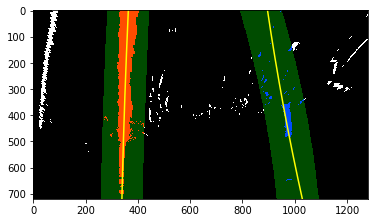

In [164]:
margin = 80

left_fitnew, right_fitnew, left_lane_indsnew, right_lane_indsnew = polyfit_prev(testImg_unwarp, left_fit, right_fit)

ploty = np.linspace(0, testImg_unwarp.shape[0]-1, testImg_unwarp.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitxnew = left_fitnew[0]*ploty**2 + left_fitnew[1]*ploty + left_fitnew[2]
right_fitxnew = right_fitnew[0]*ploty**2 + right_fitnew[1]*ploty + right_fitnew[2]

out_img = np.uint8(np.dstack((testImg_unwarp, testImg_unwarp, testImg_unwarp))*255)
window_img = np.zeros_like(out_img)

nonzero = testImg_unwarp.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_indsnew], nonzerox[left_lane_indsnew]] = [255, 0, 0]
out_img[nonzeroy[right_lane_indsnew], nonzerox[right_lane_indsnew]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitxnew, ploty, color='yellow')
plt.plot(right_fitxnew, ploty, color='yellow')
cv2.imwrite('./output_images/fit pre.jpg',result)

In [165]:
def radius(x_values):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    ploty = np.linspace(0, testImg_unwarp.shape[0]-1, testImg_unwarp.shape[0])
    y_eval = np.max(ploty)

    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = radius(left_fitx)
right_curve_rad = radius(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius = %.2f m" % average_curve_rad
print(curvature_string)

lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset = %.2f m" % center_offset_mtrs
print(offset_string)

Radius = 4958.56 m
Center offset = 0.19 m


In [166]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
 
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

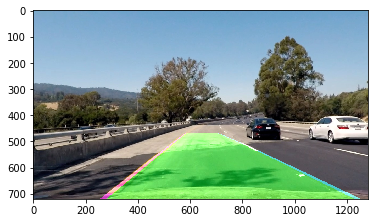

In [167]:
testImg_out1 = draw_lane(img, testImg_unwarp, left_fit, right_fit, Minv)
plt.imshow(testImg_out1)


In [168]:
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def line_average(previous_lines, new_line):
    num_frames = 12
    
    if new_line is None:      
        if len(previous_lines) == 0:
            return previous_lines, None
        else:
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def line_distance(left_line, right_line, running_average):
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    global polyfit_right
    global polyfit_left
    global past_good_right_lines
    global past_good_left_lines
    global running_mean_difference_between_lines
    
    img_size = (img.shape[1], img.shape[0])

    img_thre = thresholded_total(img)

    unwarped, M, Minv = unwarp(img_thre, src, dst)
    
    out_img = np.dstack((unwarped, unwarped, unwarped))*255
    
    non_zeros = unwarped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0])
    
    if (polyfit_left is None) or (polyfit_right is None):
        brute = True
        left_x_predictions, right_x_predictions = search_fit(unwarped)
    else:
        left_x_predictions, right_x_predictions, left_coordinates, right_coordinates = polyfit_prev(testImg_unwarp, polyfit_left, polyfit_right)
        brute = False
  
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = search_fit(unwarped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = search_fit(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = line_average(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = line_average(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, ploty]))))
    

    left_curve_rad = radius(left_x_predictions)
    right_curve_rad = radius(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius = %.2f m" % average_curve_rad

    lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
    xm_per_pix = 3.7/700 
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset =  %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped_test = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped_test, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=2)
    
    return result

True

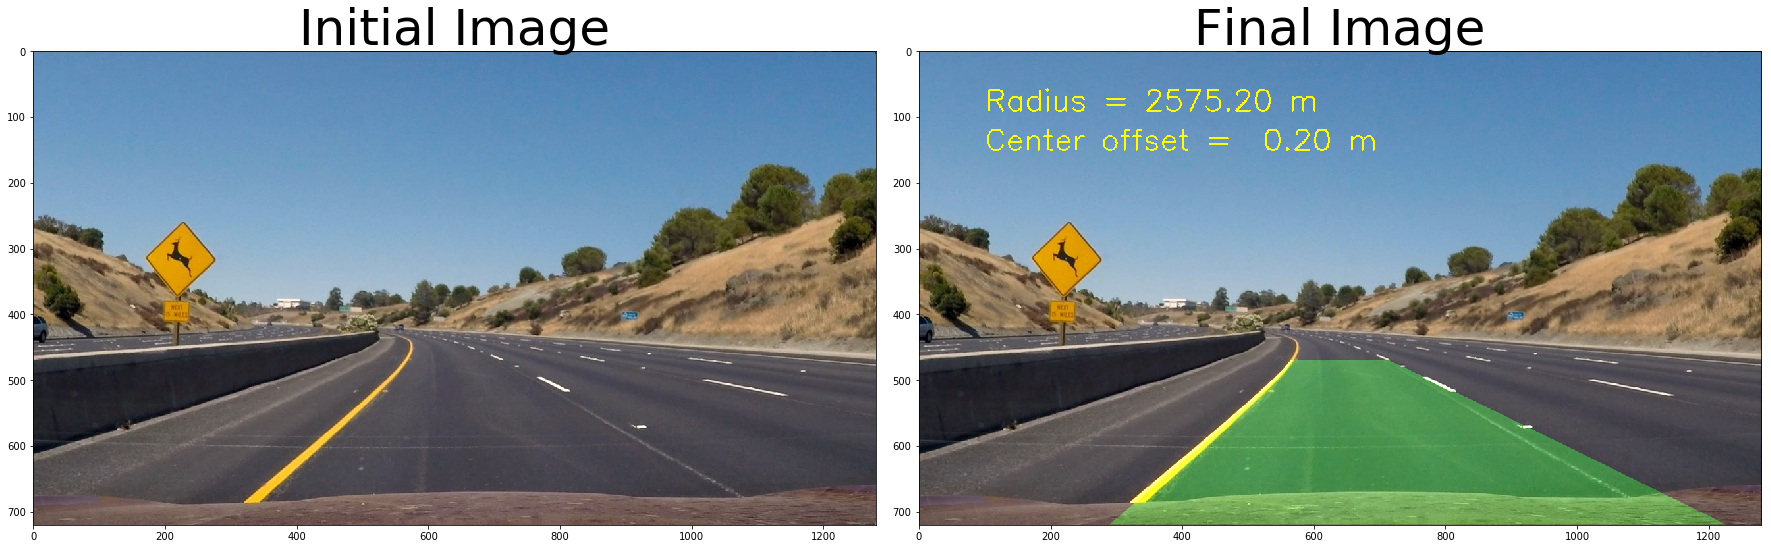

In [169]:
img = mpimg.imread('test_images/test2.jpg')

polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

processed = pipeline_final(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Initial Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Final Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('./output_images/draw lane.jpg',processed)

In [170]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [171]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = './output_video/project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_output.mp4
[MoviePy] Writing video ./output_video/project_output.mp4



100%|█████████▉| 1260/1261 [06:29<00:00,  3.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_output.mp4 

CPU times: user 4min 19s, sys: 3.36 s, total: 4min 22s
Wall time: 6min 32s


In [172]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [173]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = './output_video/challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video/challenge_output.mp4
[MoviePy] Writing video ./output_video/challenge_output.mp4


 27%|██▋       | 131/485 [00:37<01:50,  3.20it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

 27%|██▋       | 132/485 [00:37<01:47,  3.27it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

100%|█████████▉| 484/485 [02:25<00:00,  3.30it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [02:25<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/challenge_output.mp4 

CPU times: user 1min 38s, sys: 1.29 s, total: 1min 39s
Wall time: 2min 28s


In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [175]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = './output_video/harder_challenge_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video/harder_challenge_output.mp4
[MoviePy] Writing video ./output_video/harder_challenge_output.mp4


 49%|████▉     | 590/1200 [03:33<03:15,  3.12it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

 49%|████▉     | 591/1200 [03:33<03:18,  3.07it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

 52%|█████▏    | 618/1200 [03:42<03:14,  2.99it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

 52%|█████▏    | 626/1200 [03:45<03:14,  2.96it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':

 52%|█████▎    | 630/1200 [03:46<03:14,  2.93it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit m

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/harder_challenge_output.mp4 

CPU times: user 4min 23s, sys: 29.7 s, total: 4min 52s
Wall time: 7min 29s


In [176]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))